## 1.1 比特币快照数据调用

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sqlite3
import pandas as pd
import datetime

db_path = "bitcoin_data.db"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# 训练集时段
train_start = int(datetime.datetime(2018, 1, 1, 0, 0, 0).timestamp()) * 1000
train_end   = int(datetime.datetime(2024, 1, 9, 23, 59, 59).timestamp()) * 1000

# 测试集时段
test_start  = int(datetime.datetime(2024, 1, 10, 0, 0, 0).timestamp()) * 1000
test_end    = int(datetime.datetime(2025, 4, 15, 23, 59, 59).timestamp()) * 1000

# 训练集
train_query = f"""
SELECT * FROM bitcoin_data_1m
WHERE CAST(Open_time AS INTEGER) >= {train_start} AND CAST(Open_time AS INTEGER) <= {train_end}
"""
df_train = pd.read_sql(train_query, conn)

# 测试集
test_query = f"""
SELECT * FROM bitcoin_data_1m
WHERE CAST(Open_time AS INTEGER) >= {test_start} AND CAST(Open_time AS INTEGER) <= {test_end}
"""
df_test = pd.read_sql(test_query, conn)

conn.close()


print("训练集长度：", len(df_train))
print("\n测试集长度：", len(df_test))


训练集长度： 3159935

测试集长度： 644160


## 1.2 数据预处理

In [3]:
def preprocess_df(df, fill_method='ffill'):
    # 1. 转换时间戳为datetime格式
    df['Open_time'] = pd.to_datetime(df['Open_time'], unit='ms')
    df = df.set_index('Open_time')

    # 2. 补齐时间索引
    full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='1T')
    df = df.reindex(full_index)

    # 3. 填充缺失值
    if fill_method == 'ffill':
        df = df.fillna(method='ffill')
    elif fill_method == 'bfill':
        df = df.fillna(method='bfill')
    else:
        df = df.fillna(0) 

    return df


df_train = preprocess_df(df_train)
df_test = preprocess_df(df_test)
#print(df_test.isnull().sum())
#print(df_train.isnull().sum())

## 2 特征工程

#### 1. 均线类特征（SMA差分）

- **定义**：计算不同周期（短/长）的简单移动平均线（SMA），并取它们的差分归一化。
- **公式**：
$$
\text{SMA}_{\text{short}} = \frac{1}{N_{\text{short}}} \sum_{i=0}^{N_{\text{short}}-1} \text{Close}_{t-i}
$$
$$
\text{SMA}_{\text{long}} = \frac{1}{N_{\text{long}}} \sum_{i=0}^{N_{\text{long}}-1} \text{Close}_{t-i}
$$
$$
\text{SMA差分特征} = \frac{\text{SMA}_{\text{long}} - \text{SMA}_{\text{short}}}{\text{SMA}_{\text{long}}}
$$

---

#### 2. 布林带特征（Bollinger Bands）

- **定义**：计算不同窗口下的布林带上下轨，特征为当前价格与上轨的距离占整个带宽的比例。
- **公式**：
$$
\text{MA}_N = \frac{1}{N} \sum_{i=0}^{N-1} \text{Close}_{t-i}
$$
$$
\sigma_N = \sqrt{\frac{1}{N} \sum_{i=0}^{N-1} (\text{Close}_{t-i} - \text{MA}_N)^2}
$$
$$
\text{Upper} = \text{MA}_N + k \cdot \sigma_N
$$
$$
\text{Lower} = \text{MA}_N - k \cdot \sigma_N
$$
$$
\text{布林带特征} = \frac{\text{Upper} - \text{Close}_t}{\text{Upper} - \text{Lower}}
$$
其中 $k$ 一般取 2。

---

#### 3. RSI（相对强弱指标）

- **定义**：以较长周期 $N$（如 56 = 14 × 4）计算 RSI，反映超买超卖状态。
- **公式**：
$$
\text{RSI} = 100 \times \frac{\text{平均上涨幅度}}{\text{平均上涨幅度} + \text{平均下跌幅度}}
$$
其中平均上涨幅度、平均下跌幅度分别为周期内正涨幅、负涨幅的均值。

---

#### 4. NATR（归一化真实波幅）

- **定义**：以长周期 $N$ 计算 NATR，衡量波动率，归一化到当前价格。
- **公式**：
$$
\text{TR}_i = \max \left\{ \text{High}_i - \text{Low}_i, |\text{High}_i - \text{Close}_{i-1}|, |\text{Low}_i - \text{Close}_{i-1}| \right\}
$$
$$
\text{ATR}_N = \frac{1}{N} \sum_{i=0}^{N-1} \text{TR}_{t-i}
$$
$$
\text{NATR} = \frac{\text{ATR}_N}{\text{Close}_t}
$$

---

#### 5. DI+/DI-（动向指标）

- **定义**：以不同周期 $N$ 计算正向/负向动向指标，反映上涨/下跌动能。
- **公式**：
$$
\text{DM}^+_i = \max(\text{High}_i - \text{High}_{i-1}, 0)
$$
$$
\text{DM}^-_i = \max(\text{Low}_{i-1} - \text{Low}_i, 0)
$$
$$
\text{DI}^+_N = 100 \times \frac{\sum_{i=0}^{N-1} \text{DM}^+_{t-i}}{\sum_{i=0}^{N-1} \text{TR}_{t-i}}
$$
$$
\text{DI}^-_N = 100 \times \frac{\sum_{i=0}^{N-1} \text{DM}^-_{t-i}}{\sum_{i=0}^{N-1} \text{TR}_{t-i}}
$$

---

#### 6. 对数收益率（Log Return）

- **定义**：现价与前一窗口价的对数差，含滞后（lag=0,1,2）。
- **公式**：
$$
r_t^{(\text{lag}=k)} = \ln\left(\frac{\text{Close}_t}{\text{Close}_{t-15(k+1)}}\right)
$$

---

#### 7. 上下影线占比

- **定义**：近15分钟最高价与收/开价的比例（上影线），最低价与收/开价的比例（下影线），反映K线形态。
- **公式**：
  - 上影线占比：
    $$
    \text{上影线占比} = \frac{\max(\text{High}_{t-14}, ..., \text{High}_t) \times 100}{\max(\text{Close}_t, \text{Open}_{t-15})}
    $$
  - 下影线占比：
    $$
    \text{下影线占比} = \frac{\min(\text{Close}_t, \text{Open}_{t-15}) \times 100}{\min(\text{Low}_{t-14}, ..., \text{Low}_t)}
    $$

---

#### 8. 主动买入特征
$$
\text{主动买入BTC占比} = \frac{\sum_{i=0}^{N-1} \text{TakerBuyBaseAssetVolume}_{t-i}}{\sum_{i=0}^{N-1} \text{Volume}_{t-i}}
$$

$$
\text{主动买入计价币占比} = \frac{\sum_{i=0}^{N-1} \text{TakerBuyQuoteAssetVolume}_{t-i}}{\sum_{i=0}^{N-1} \text{QuoteAssetVolume}_{t-i}}
$$

$$
\text{主动买入强度差分} = \frac{1}{N_{\text{short}}} \sum_{i=0}^{N_{\text{short}}-1} \text{TakerBuyBaseAssetVolume}_{t-i}
- \frac{1}{N_{\text{long}}} \sum_{i=0}^{N_{\text{long}}-1} \text{TakerBuyBaseAssetVolume}_{t-i}
$$

In [4]:
import pandas as pd
import numpy as np

def calc_sma_diff(close, timeperiod_short, timeperiod_long):
    res_short = close[-timeperiod_short:].mean()
    res_long = close[-timeperiod_long:].mean()
    res = (res_long - res_short) / res_long
    return res

def calc_bbands(close, timeperiod, std=2):
    close_std = close[-timeperiod:].std(ddof=0)
    rol = close[-timeperiod:].mean()
    upper = rol + close_std * std
    lower = rol - close_std * std
    res = (upper - close[-1]) / (upper - lower)
    return res

def calc_rsi(close, timeperiod):
    diff = np.diff(close[-(timeperiod+1):])
    A = diff[diff>0].sum() / timeperiod
    B = -diff[diff<0].sum() / timeperiod
    rsi = 100 * A / (A + B)
    return rsi

def calc_atr(high, low, close, timeperiod):
    A = high[-timeperiod:] - close[-(timeperiod+1):-1]
    B = close[-(timeperiod+1):-1] - low[-timeperiod:]
    C = high[-timeperiod:] - low[-timeperiod:]
    res = np.vstack((A, B, C)).max(axis=0).mean()
    return res

def calc_natr(high, low, close, timeperiod):
    res = calc_atr(high, low, close, timeperiod) / close[-1]
    return res

def calc_minus_di(high, low, close, timeperiod):
    high_diff = np.diff(high[-(timeperiod+1):])
    low_diff = np.diff(low[-(timeperiod+1):])
    high_diff[(high_diff<0)] = 0
    low_diff[(low_diff<0)] = 0
    low_diff[(high_diff>low_diff)] = 0
    tr = calc_atr(high, low, close, timeperiod)*timeperiod
    res = 100 * low_diff.sum() / tr
    return res

def calc_plus_di(high, low, close, timeperiod):
    high_diff = np.diff(high[-(timeperiod+1):])
    low_diff = np.diff(low[-(timeperiod+1):])
    high_diff[(high_diff<0)] = 0
    low_diff[(low_diff<0)] = 0
    high_diff[(high_diff<low_diff)] = 0
    tr = calc_atr(high, low, close, timeperiod)*timeperiod
    res = 100 * high_diff.sum() / tr
    return res

def calc_log_ret(close, lag=0):
    return np.log(close[-(1+15*lag)] / close[-(1+15*(lag+1))])

def upper_shadow_15_perc(high, close, open_, lag=0):
    if lag:
        return high[-15*(lag+1):-15*lag].max() * 100 / np.maximum(close[-15*lag-1], open_[-15*(lag+1)-1])
    else:
        return high[-15:].max() * 100 / np.maximum(close[-1], open_[-16])

def lower_shadow_15_perc(low, close, open_, lag=0):
    if lag:
        return np.minimum(close[-15*lag-1], open_[-15*(lag+1)-1]) * 100 / low[-15*(lag+1):-15*lag].min()
    else:
        return np.minimum(close[-1], open_[-16]) * 100 / low[-15:].min()

# 主动买入相关
def taker_buy_ratio_base(volume, taker_buy_base_asset_volume, window=15):
    vol = volume[-window:].sum()
    buy = taker_buy_base_asset_volume[-window:].sum()
    return buy / vol if vol > 0 else 0

def taker_buy_ratio_quote(quote_asset_volume, taker_buy_quote_asset_volume, window=15):
    vol = quote_asset_volume[-window:].sum()
    buy = taker_buy_quote_asset_volume[-window:].sum()
    return buy / vol if vol > 0 else 0

def taker_buy_strength_diff(taker_buy_base_asset_volume, short=15, long=60):
    short_mean = taker_buy_base_asset_volume[-short:].mean()
    long_mean = taker_buy_base_asset_volume[-long:].mean()
    return short_mean - long_mean

In [16]:
def get_features(df, open_, high, low, close, volume, 
                 quote_asset_volume, taker_buy_base_asset_volume, taker_buy_quote_asset_volume):
    # close: 当前行向前一共 row_num = 24*4*4*4*4 + 50 行，最后一行就是当前行
    res = []
    res.append(calc_sma_diff(close, 12, 26))
    res.append(calc_sma_diff(close, 12*4*4, 24*4*4))
    res.append(calc_sma_diff(close, 12*4*4*4, 24*4*4*4))
    res.append(calc_sma_diff(close, 12*4*4*4*4, 24*4*4*4*4))
    res.append(calc_sma_diff(volume, 12*4*4, 24*4*4))
    res.append(calc_rsi(close, 14*4))
    res.append(calc_natr(high, low, close, 14*4*4*4))
    res.append(calc_minus_di(high, low, close, 14))
    res.append(calc_minus_di(high, low, close, 14*4*4*4))
    res.append(calc_plus_di(high, low, close, 14*4))
    res.append(calc_plus_di(high, low, close, 14*4*4*4))
    res.append(calc_log_ret(close))
    res.append(calc_log_ret(close, lag=1))
    res.append(calc_log_ret(close, lag=2))
    res.append(upper_shadow_15_perc(high, close, open_))
    res.append(lower_shadow_15_perc(low, close, open_))
    res.append(calc_bbands(close, 5*4*2))
    res.append(calc_bbands(close, 5*4*4))
    res.append(calc_bbands(close, 5*4*4*2))
    res.append(calc_bbands(close, 5*4*4*4))
    # 主动买入特征
    res.append(taker_buy_ratio_base(volume, taker_buy_base_asset_volume, window=15))
    res.append(taker_buy_ratio_quote(quote_asset_volume, taker_buy_quote_asset_volume, window=15))
    res.append(taker_buy_strength_diff(taker_buy_base_asset_volume, short=15, long=60))
    
    return res

In [ ]:
def extract_features(df):
    
    return get_features(
        df,
        df["Open"].values,
        df["High"].values,
        df["Low"].values,
        df["Close"].values,
        df["Volume"].values,
        df["Quote_asset_volume"].values,
        df["Taker_buy_base_asset_volume"].values,
        df["Taker_buy_quote_asset_volume"].values
    )
def get_dataset_features(df):
    row_num = 24*4*4*4*4 + 50
    feature_names = [f'feature{i+1}' for i in range(23)]
    idx = 0

    # 用于收集所有样本
    records = []
    import tqdm
    for date, _ in tqdm.tqdm(df.iterrows()):
        if idx < row_num:
            idx += 1
            continue
        current_index = idx
        start_index = max(0, current_index - row_num)
        new_df = df.iloc[start_index:current_index + 1].copy()

        idx += 1
        features = extract_features(new_df)
        records.append([date] + list(features))

    final_feature_df = pd.DataFrame(records, columns=['idx'] + feature_names)
    return final_feature_df

# # 计算特征，但是已经计算过并且保存了，因此只需要加载即可
# final_feature_df_train = get_dataset_features(df_train)
# final_feature_df_test = get_dataset_features(df_test)



3168000it [55:20, 954.17it/s]
644160it [11:13, 956.71it/s]


In [ ]:
# final_feature_df_train.to_csv('final_feature_df_train.csv', index=False, encoding='utf-8')
# final_feature_df_test.to_csv('final_feature_df_test.csv', index=False, encoding='utf-8')
final_feature_df_train = pd.read_csv('final_feature_df_train.csv')
final_feature_df_test = pd.read_csv('final_feature_df_test.csv')


In [19]:
# print(final_feature_df_train.head())
print(len(final_feature_df_train))
print(len(final_feature_df_test))
print(len(df_train))
print(len(df_test))

3161806
637966
3168000
644160


In [20]:
def add_target(df, N=15):
    import numpy as np
    
    # 计算R^a(t) - 从t+1到t+16的对数收益率
    
    df['R_a'] = np.log(df['Close'].shift(-15) / df['Close']) 
    window_size = 3750  
    df['M_t'] = df['R_a'].rolling(window=window_size, min_periods=1).mean()

    # 2. 计算β (使用一个固定时间段的数据)
    beta_window = min(len(df), 3750*2)  
    
   
    if len(df) > beta_window:
        R_a_sample = df['R_a'].iloc[-beta_window:].dropna()
        M_t_sample = df['M_t'].iloc[-beta_window:].dropna()
        
        # 计算<M·R^a>和<M^2>
        M_R_product = (M_t_sample * R_a_sample).mean()
        M_squared = (M_t_sample**2).mean()
        
        # 计算β
        beta = M_R_product / M_squared if M_squared != 0 else 1.0
    else:   
        beta = 0.9  

    # 3. 计算Target(t) = R^a(t) - β^a·M(t)
    df['target'] = df['R_a'] - beta * df['M_t']
    
    df = df.drop(columns=['R_a', 'M_t'])
    df = df.dropna(subset=['target'])
    
    return df

In [21]:
N = 15  
df_train_target=add_target(df_train,N)
df_test_target=add_target(df_test,N)


In [22]:
print(len(df_train_target))
print(len(df_test_target))
print(df_train_target)

3167985
644145
                         Open      High       Low     Close      Volume  \
2017-12-31 16:00:00  13226.16  13277.85  13192.02  13246.35    6.249564   
2017-12-31 16:01:00  13277.83  13301.49  13246.50  13300.18   11.117665   
2017-12-31 16:02:00  13280.06  13350.00  13267.71  13332.32   18.448583   
2017-12-31 16:03:00  13313.02  13380.14  13313.02  13380.14   11.776241   
2017-12-31 16:04:00  13369.99  13462.00  13359.45  13417.73   21.192539   
...                       ...       ...       ...       ...         ...   
2024-01-09 15:40:00  46914.77  46961.00  46912.43  46941.72   59.375430   
2024-01-09 15:41:00  46941.71  46970.56  46941.71  46967.99   61.354190   
2024-01-09 15:42:00  46967.98  47010.00  46939.12  46990.42  184.693620   
2024-01-09 15:43:00  46990.41  47004.00  46679.00  46901.10  235.744670   
2024-01-09 15:44:00  46901.10  46984.00  46901.09  46955.77  120.572950   

                        Close_time  Quote_asset_volume  Number_of_trades  \
2017-12-

In [23]:
row_num = 24*4*4*4*4 + 50
df_train_target = df_train_target.iloc[row_num:].copy()
df_test_target = df_test_target.iloc[row_num:].copy()
print(len(df_test_target))

637951


In [24]:
feature_names = [f'feature{i+1}' for i in range(23)]
# print(feature_names)
X_train = final_feature_df_train[feature_names][:-N]
y_train = df_train_target["target"]
X_test = final_feature_df_test[feature_names][:-N]
y_test = df_test_target["target"]

print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

3161791
3161791
637951
637951


In [25]:
# %pip install lightgbm
from lightgbm import LGBMRegressor
model = LGBMRegressor(
    # learning_rate= 0.01,
    # n_estimators= 100,
    # num_leaves= 31,
    # subsample= 0.8,
    n_jobs=1
)



In [26]:
model = model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.183906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5865
[LightGBM] [Info] Number of data points in the train set: 3161791, number of used features: 23
[LightGBM] [Info] Start training from score 0.000001


皮尔逊相关系数: 0.0220


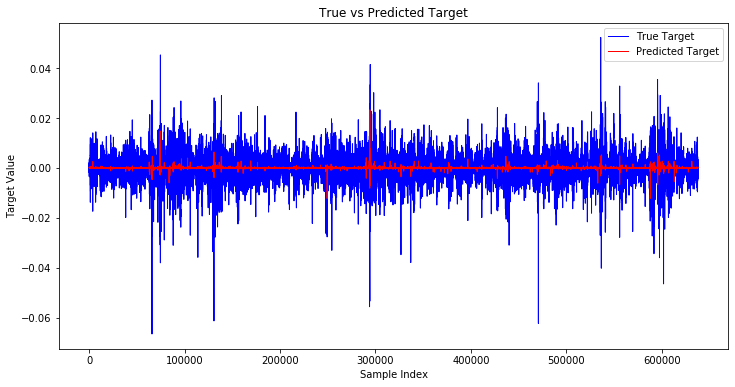

In [27]:
#测试集表现
y_pred = model.predict(X_test)
y_test_values = y_test.values

from scipy.stats import pearsonr

corr, _ = pearsonr(y_test_values, y_pred)
print(f"皮尔逊相关系数: {corr:.4f}")

import matplotlib.pyplot as plt


%matplotlib inline
plt.figure(figsize=(12, 6))
plt.plot(y_test_values, label='True Target', color='blue', linewidth=1)
plt.plot(y_pred, label='Predicted Target', color='red', linewidth=1)
plt.title('True vs Predicted Target')
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.show()



皮尔逊相关系数: 0.3621


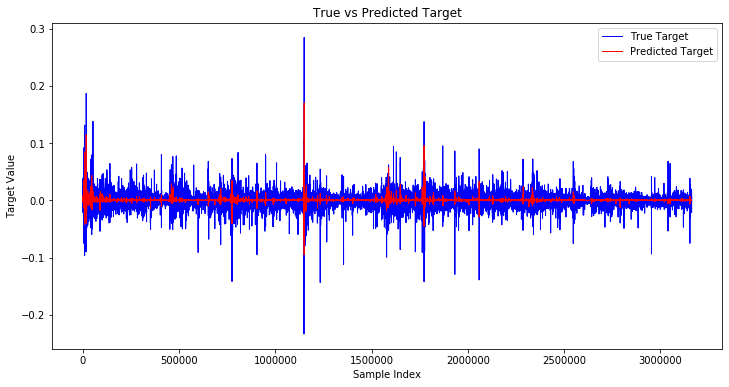

In [28]:
#训练集表现
y_pred_train = model.predict(X_train)
y_train_values = y_train.values

from scipy.stats import pearsonr

corr, _ = pearsonr(y_train_values, y_pred_train)
print(f"皮尔逊相关系数: {corr:.4f}")

import matplotlib.pyplot as plt


%matplotlib inline
plt.figure(figsize=(12, 6))
plt.plot(y_train_values, label='True Target', color='blue', linewidth=1)
plt.plot(y_pred_train, label='Predicted Target', color='red', linewidth=1)
plt.title('True vs Predicted Target')
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.show()

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("***test set***")
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')

print()
print("***train set***")
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train, y_pred_train)
r2 = r2_score(y_train, y_pred_train)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')


***test set***
MSE: 8.026797545925138e-06
RMSE: 0.0028331603459608736
MAE: 0.0018441451367608795
R2: -0.002006775366450775

***train set***
MSE: 1.4581201618119621e-05
RMSE: 0.0038185339618916083
MAE: 0.002241546947147081
R2: 0.10101456409660425


In [30]:
# # 将预测结果转换为涨跌信号
# y_pred_direction = np.where(y_pred > 0, 1, -1)
# y_test_direction = np.where(y_test_values > 0, 1, -1)
# correct_predictions = (y_pred_direction == y_test_direction).astype(int)

# # 计算普通准确率
# accuracy = correct_predictions.mean()
# print(f"普通准确率: {accuracy:.4f}")

# # 计算按实际收益率绝对值加权的准确率
# weights = np.abs(y_test_values)
# weighted_correct = correct_predictions * weights
# weighted_accuracy = weighted_correct.sum() / weights.sum()
# print(f"按收益率绝对值加权的准确率: {weighted_accuracy:.4f}")


# up_indices = y_test_values > 0
# down_indices = y_test_values <= 0

# if len(y_test_values[up_indices]) > 0:
#     up_accuracy = correct_predictions[up_indices].mean()
#     print(f"上涨预测准确率: {up_accuracy:.4f} (样本数: {len(y_test_values[up_indices])})")

# if len(y_test_values[down_indices]) > 0:
#     down_accuracy = correct_predictions[down_indices].mean()
#     print(f"下跌预测准确率: {down_accuracy:.4f} (样本数: {len(y_test_values[down_indices])})")

# # 可视化混淆矩阵
# from sklearn.metrics import confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns

# cm = confusion_matrix(y_test_direction, y_pred_direction)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
#             xticklabels=['down', 'up'], 
#             yticklabels=['down', 'up'])
# plt.xlabel('pred')
# plt.ylabel('true')
# plt.title('confusion matrix')
# plt.show()

# avg_return_when_correct = y_test_values[correct_predictions == 1].mean()
# avg_return_when_wrong = y_test_values[correct_predictions == 0].mean()

# print(f"预测正确时的平均收益率: {avg_return_when_correct:.6f}")
# print(f"预测错误时的平均收益率: {avg_return_when_wrong:.6f}")

In [ ]:
# from sklearn.model_selection import TimeSeriesSplit
# from sklearn.metrics import mean_squared_error, r2_score
# import numpy as np
# import matplotlib.pyplot as plt

# # 设置TimeSeriesSplit
# n_splits = 5  # 分割次数
# tscv = TimeSeriesSplit(n_splits=n_splits)

# # 存储每次分割的评估结果
# cv_scores = []
# cv_predictions = []

# plt.figure(figsize=(15, 10))

# for i, (train_index, test_index) in enumerate(tscv.split(X_train)):
#     # 获取当前折的训练和测试数据
#     X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
#     y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
#     # 训练模型
#     fold_model = LGBMRegressor(n_jobs=1)
#     fold_model.fit(X_train_fold, y_train_fold)
    
#     # 预测并评估
#     y_pred_fold = fold_model.predict(X_test_fold)
#     mse = mean_squared_error(y_test_fold, y_pred_fold)
#     r2 = r2_score(y_test_fold, y_pred_fold)
#     cv_scores.append({'fold': i+1, 'MSE': mse, 'R2': r2})
    
#     # 绘制每个时间窗口的预测结果
#     plt.subplot(n_splits, 1, i+1)
#     plt.plot(y_test_fold.values, label=f'True (Fold {i+1})', color='blue', linewidth=1)
#     plt.plot(y_pred_fold, label=f'Predicted (Fold {i+1})', color='red', linewidth=1)
#     plt.title(f'Fold {i+1}: MSE={mse:.6f}, R²={r2:.4f}')
#     plt.legend()

# plt.tight_layout()
# plt.show()

# # 打印每个折的评估结果
# for score in cv_scores:
#     print(f"Fold {score['fold']}: MSE={score['MSE']:.6f}, R²={score['R2']:.4f}")

# # 计算平均评估指标
# avg_mse = np.mean([score['MSE'] for score in cv_scores])
# avg_r2 = np.mean([score['R2'] for score in cv_scores])
# print(f"\n平均评估结果: MSE={avg_mse:.6f}, R²={avg_r2:.4f}")

In [ ]:
# from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
# from lightgbm import LGBMRegressor
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# # 定义参数网格
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [-1, 5, 7, 9],  # -1表示无限制
#     'num_leaves': [31, 63, 127],
#     'min_child_samples': [20, 30, 50],
#     'subsample': [0.7, 0.8, 0.9],
#     'colsample_bytree': [0.7, 0.8, 0.9],
#     'reg_alpha': [0, 0.1, 0.5],
#     'reg_lambda': [0, 0.1, 0.5]
# }
# def pearson_scorer(y_true, y_pred):
#     try:
#         corr, _ = pearsonr(y_true, y_pred)
#         return corr if not np.isnan(corr) else 0.0
#     except:
#         return 0.0


# # 更小的初始参数网格
# small_param_grid = {
#     'n_estimators': [100, 300],
#     'learning_rate': [0.01, 0.1],
#     'num_leaves': [31, 127],
#     'subsample': [0.8, 1.0],
# }

# # 使用TimeSeriesSplit进行时间序列交叉验证
# tscv = TimeSeriesSplit(n_splits=3)

# # 初始化LGBMRegressor
# lgbm = LGBMRegressor(n_jobs=-1, random_state=42)

# # 创建GridSearchCV对象
# grid_search = GridSearchCV(
#     estimator=lgbm,
#     param_grid=small_param_grid,  # 使用小参数网格开始
#     cv=tscv,
#     scoring=pearson_scorer, 
#     verbose=2,
#     n_jobs=-1  # 使用所有可用CPU
# )

# grid_search.fit(X_train, y_train)

# # 输出最佳参数
# print("最佳参数组合:")
# for param, value in grid_search.best_params_.items():
#     print(f"{param}: {value}")

# print(f"\n最佳交叉验证分数: {-grid_search.best_score_:.6f} (MSE)")

# # 使用最佳参数创建模型
# best_model = LGBMRegressor(**grid_search.best_params_, n_jobs=-1, random_state=42)
# best_model.fit(X_train, y_train)

# y_pred_best = best_model.predict(X_test)
# mse_best = mean_squared_error(y_test, y_pred_best)
# r2_best = r2_score(y_test, y_pred_best)

# print(f"\n使用最佳参数的测试集表现:")
# print(f"MSE: {mse_best:.6f}")
# print(f"RMSE: {np.sqrt(mse_best):.6f}")
# print(f"R²: {r2_best:.4f}")
